In [1]:

import datasets
import pandas as pd

# loading existing datasets

In [3]:
emotions = datasets.load_dataset("emotion")

Using custom data configuration default
Reusing dataset emotion (/Users/SPayot/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705)


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
emotions["train"].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

# Generating own datasets
## generating the data

In [50]:
FPATH = "../data/simple_dataset.csv"

data={"text": ["i love kyries", "best running shoes", "cleats for forwards", "everyday cool looking snkrs", "new pegs"], 
"category": ["basketball", "running", "global football", "lifestyle", "running"]}

df = pd.DataFrame(data)

df.to_csv(FPATH)

df

,text,category
0,i love kyries,basketball
1,best running shoes,running
2,cleats for forwards,global football
3,everyday cool looking snkrs,lifestyle
4,new pegs,running


## creating a Dataset from a pandas dataframe

In [42]:
from collections import OrderedDict

label2id =  OrderedDict({"basketball": 0, "running": 1, "global football": 2, "lifestyle": 3, "other": 4})

In [59]:
ds_pd = datasets.Dataset.from_pandas(df) #, info="a toy example of dataset")




def convert_category(example: dict) -> dict[str, int]:
    return {"label": label2id.get(example["category"])}
    
ds_pd = ds_pd.map(convert_category)

ds_pd

  0%|          | 0/5 [00:00<?, ?ex/s]

Dataset({
    features: ['text', 'category', 'label'],
    num_rows: 5
})

In [63]:
def print_dict(d: dict) -> None:
    print(*[f"\t{k}: {v}" for k, v in d.items()], sep='\n')
    
def print_ds(ds):
    print_dict(ds.features)
    print()
    print_dict(ds[:])

print_ds(ds_pd)

	text: Value(dtype='string', id=None)
	category: Value(dtype='string', id=None)
	label: Value(dtype='int64', id=None)

	text: ['i love kyries', 'best running shoes', 'cleats for forwards', 'everyday cool looking snkrs', 'new pegs']
	category: ['basketball', 'running', 'global football', 'lifestyle', 'running']
	label: [0, 1, 2, 3, 1]


## setting right feature types

In [66]:
df["label"] = df.category.map(label2id)

In [71]:
features = datasets.Features({
    "label": datasets.ClassLabel(names=list(label2id.keys())),
    "text": datasets.Value(dtype="string"),
    "category": datasets.Value(dtype="string"),
    })

ds_pd2 = datasets.Dataset.from_pandas(df, features=features)
print_ds(ds_pd2)

	label: ClassLabel(num_classes=5, names=['basketball', 'running', 'global football', 'lifestyle', 'other'], id=None)
	text: Value(dtype='string', id=None)
	category: Value(dtype='string', id=None)

	label: [0, 1, 2, 3, 1]
	text: ['i love kyries', 'best running shoes', 'cleats for forwards', 'everyday cool looking snkrs', 'new pegs']
	category: ['basketball', 'running', 'global football', 'lifestyle', 'running']


In [79]:
# split
ds_pd2 = ds_pd2.shuffle(seed=42).train_test_split(.2)

In [80]:
# save to disk in arrow format
ds_pd2.save_to_disk("data/simple_dataset/")

Flattening the indices:   0%|          | 0/1 [00:00<?, ?ba/s]

Flattening the indices:   0%|          | 0/1 [00:00<?, ?ba/s]

# try to handle transforms

In [1]:
import requests, io
from io import BytesIO
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import datasets

In [2]:
import psutil

def get_ram_usage_mb() -> float:
    return psutil.Process().memory_info().rss / (1024 * 1024)

def print_ram_usage() -> None:
    # Process.memory_info is expressed in bytes, so convert to megabytes
    print(f"RAM used: {get_ram_usage_mb():.2f} MB")

print_ram_usage()

RAM used: 253.56 MB


In [4]:
filepath = "https://static.nike.com/a/images/t_default/b23b37f4-1278-4719-8290-4c673d3ef1e0/sportswear-womens-fleece-sweatshirt-vgstZS.png"
image_path = "data/image_sample.jpg"
img = Image.open(BytesIO(requests.get(filepath).content)).convert('RGB').resize((300,300))
img.save(image_path)


In [5]:
N = 1000


data = {
    "filepath": [image_path for _ in range(N)], 
    "label": ["cat" for _ in range(N)],
    }

ds = datasets.Dataset.from_dict(data)

print("before:")
print_ram_usage()

# open images and save to dataset
# def read_image(examples):
#     return {"pixel_values": [Image.open(BytesIO(requests.get(filepath).content)).convert('RGB').resize((300,300)) for filepath in examples["filepath"]]}

def read_image(examples):
    return {"images": [Image.open(image_path).convert('RGB').resize((300,300)) for filepath in examples["filepath"]]}


ds = ds.map(read_image, remove_columns=["filepath"], batched=True, batch_size=32)

print(f"after creating datasets.Dataset with {N} images")
print_ram_usage()


# new_img = [Image.open(BytesIO(requests.get(filepath).content)).convert('RGB') for _ in range(N)]

# print(f"after adding {N} images on disk")
# print_ram_usage()

# del new_img
# del ds

before:
RAM used: 281.00 MB


  0%|          | 0/32 [00:00<?, ?ba/s]

after creating datasets.Dataset with 1000 images
RAM used: 492.19 MB


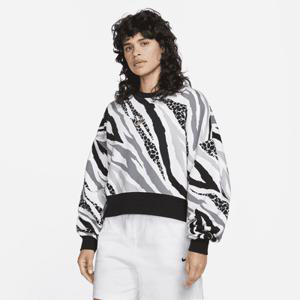

In [6]:
ds[900]["pixel_values"]

In [11]:
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

print_ram_usage()


def encode(examples):
    return processor(images=examples["pixel_values"])

ds = ds.map(encode, batched=True, batch_size=32)

print_ram_usage()

RAM used: 517.58 MB


  0%|          | 0/32 [00:00<?, ?ba/s]

RAM used: 1183.23 MB


In [6]:
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [7]:
N = 1000

img_path = "your/image/path/on/s3"
filepath = "https://static.nike.com/a/images/t_default/b23b37f4-1278-4719-8290-4c673d3ef1e0/sportswear-womens-fleece-sweatshirt-vgstZS.png"
data = {
    "filepath": [filepath for _ in range(N)], 
    "label": ["cat" for _ in range(N)],
    }

ds = datasets.Dataset.from_dict(data)


def single_pass(examples):
    imgs = [Image.open(image_path).convert('RGB').resize((300,300)) for filepath in examples["filepath"]]
    return processor(images=imgs)


from time import perf_counter


def get_time_and_mem() -> tuple[float, float]: 

    return perf_counter(), psutil.Process(os.getpid()).memory_info().rss / (1024 * 1024)

In [26]:
N = 1000

img_path = "your/image/path/on/s3"
image_path = "data/image_sample.jpg"
filepath = "https://static.nike.com/a/images/t_default/b23b37f4-1278-4719-8290-4c673d3ef1e0/sportswear-womens-fleece-sweatshirt-vgstZS.png"
data = {
    "filepath": [image_path for _ in range(N)], 
    "label": ["cat" for _ in range(N)],
    }

ds = datasets.Dataset.from_dict(data)

def single_pass(examples):
    # imgs = [Image.open(BytesIO(requests.get(filepath).content)).convert('RGB').resize((300,300)) for filepath in examples["filepath"]]
    imgs = [Image.open(filepath).convert('RGB').resize((300,300)) for filepath in examples["filepath"]]
    return processor(images=imgs)

before = get_time_and_mem()
ds = ds.map(single_pass, batched=True, batch_size=256)
after = get_time_and_mem()

print(f"memory used: {after[1]-before[1]:.2f}MB")
print(f"latency: {after[0]-before[0]:.2f} sec")

del ds

  0%|          | 0/4 [00:00<?, ?ba/s]

memory used: 565.58MB
latency: 3.30 sec


In [3]:
import requests, io
from io import BytesIO
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import datasets

# defining benchmarking class

In [16]:
import os
import psutil
from time import perf_counter

def get_time_and_mem() -> tuple[float, float]: 

    return perf_counter(), psutil.Process(os.getpid()).memory_info().rss / (1024 * 1024)


class PerfCheck:
    def __init__(self):
        """measures the impact on RAM and time of a python execution.
        Example:
        >>> pc = PerfCheck()
        >>> pc.start()
        >>> time.sleep(1)
        >>> pc.stop()
        """
        self.memory : tuple[float, float] = None
        self.cpu_perf : tuple[float, float] = None
        self.status : str = "INITIALIZED"

    def start(self) -> None:
        self.memory = self._get_ram_mb()
        self.cpu_perf = self._get_time()
        self.status = "RUNNING"

    def stop(self) -> None:
        self.memory = self._get_ram_mb() - self.memory
        self.cpu_perf = self._get_time() - self.cpu_perf
        self.status = "COMPLETED"

    def print(self) -> None:
        print(f"memory used: {self.after[1] - self.before[1]:.2f}MB")
        print(f"latency: {self.after[0] - self.before[0]:.2f} sec")

    def reset(self) -> None:
        self.__init__()

    def __repr__(self) -> str:
        if self.status == "COMPLETED":
            return f"PerfCheck(status={self.status}, cpu_perf={self.cpu_perf:.2f} sec, memory={self.memory:.2f}MB)"
        return f"PerfCheck(status={self.status})"

    def _get_time(self) -> float:
        return perf_counter()

    def _get_ram_mb(self) -> float:
        return psutil.Process(os.getpid()).memory_info().rss / (1024 * 1024)

    


def query_dataset(ds, batch_size, n_inferences):
    print(f"querying {n_inferences} batches of size {batch_size} the dataset")
    pc = PerfCheck()
    pc.start()
    for i in range(n_inferences):
        _ = ds[i:i+batch_size]["pixel_values"]
    pc.stop()
    print(pc)

# defining dataset

In [5]:
N = 1000

img_path = "your/image/path/on/s3"
image_path = "data/image_sample.jpg"
filepath = "https://static.nike.com/a/images/t_default/b23b37f4-1278-4719-8290-4c673d3ef1e0/sportswear-womens-fleece-sweatshirt-vgstZS.png"
data = {
    "filepath": [image_path for _ in range(N)], 
    "label": ["cat" for _ in range(N)],
    }

ds = datasets.Dataset.from_dict(data)

In [6]:
# load image tokenizer
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [9]:


def single_pass(examples):
    # imgs = [Image.open(BytesIO(requests.get(filepath).content)).convert('RGB').resize((300,300)) for filepath in examples["filepath"]]
    imgs = [Image.open(filepath).convert('RGB').resize((300,300)) for filepath in examples["filepath"]]
    return processor(images=imgs)


pc = PerfCheck()
print("transforming dataset")
pc.start()
ds2 = ds.map(single_pass, batched=True, batch_size=256)
pc.stop()
print(pc)


N_INFERENCES = 100
BATCH_SIZE = 16

query_dataset(ds2, n_inferences=N_INFERENCES, batch_size=BATCH_SIZE)

transforming dataset


  0%|          | 0/4 [00:00<?, ?ba/s]

memory used: 182.77MB
latency: 3.29 sec
querying 100 batches of size 16 the dataset
memory used: -290.22MB
latency: 56.84 sec


## using with_transform instead
`with_transform` operates the requested transformation only on the fly

In [21]:
import requests, io
from io import BytesIO
from PIL import Image
from transformers import CLIPProcessor
import datasets

DATASET_SIZE = 100
IMAGE_PATH = "http://images.cocodataset.org/val2017/000000039769.jpg"
# "https://static.nike.com/a/images/t_default/b23b37f4-1278-4719-8290-4c673d3ef1e0/sportswear-womens-fleece-sweatshirt-vgstZS.png"
IMAGE_PATH = "https://images.nike.com/is/image/DotCom/PDP_HERO/SX5547_010_A/DotCom_SX5547-010.png?wid=300&hei=300&fmt=png-alpha"
MODEL_CKPT = "openai/clip-vit-base-patch32"

# querying test parameters
N_INFERENCES = 10
BATCH_SIZE = 16


# create synthetic dataset
data = {
    "filepath": [IMAGE_PATH for _ in range(DATASET_SIZE)],
    "label": ["hoodie" for _ in range(DATASET_SIZE)]
}

ds = datasets.Dataset.from_dict(data)


# pre-processing pipeline: filepath > Image > Tokens
processor = CLIPProcessor.from_pretrained(MODEL_CKPT)

def get_image_from_path(filepath):
    return (
        Image.open(BytesIO(requests.get(filepath).content))
        .convert('RGB')
        # .resize((300,300))
        )

def _transform(examples):
    """note: with_transform requires to define all"""
    imgs = [get_image_from_path(filepath) for filepath in examples["filepath"]]
    examples.update(processor(images=imgs, return_tensors='pt'))
    examples.pop('filepath')
    return examples

ds2 = ds.with_transform(_transform)

query_dataset(ds2, n_inferences=N_INFERENCES, batch_size=BATCH_SIZE)


querying 10 batches of size 16 the dataset
PerfCheck(status=COMPLETED, cpu_perf=83.32 sec, memory=118.05MB)


In [23]:
ds2[0]

{'label': 'hoodie',
 'pixel_values': tensor([[[ 0.5873,  0.5873,  0.6165,  ...,  0.0617,  0.0471, -0.0259],
          [ 0.5727,  0.5727,  0.6603,  ...,  0.1201,  0.0763,  0.0909],
          [ 0.5873,  0.5435,  0.6165,  ...,  0.0325,  0.1201,  0.0617],
          ...,
          [ 1.8719,  1.8573,  1.8719,  ...,  1.3902,  1.4340,  1.4194],
          [ 1.8281,  1.8719,  1.8427,  ...,  1.4486,  1.4340,  1.5070],
          [ 1.8573,  1.9011,  1.8281,  ...,  1.3756,  1.3610,  1.4486]],
 
         [[-1.3169, -1.3019, -1.3169,  ..., -1.4970, -1.4369, -1.4820],
          [-1.2418, -1.2718, -1.2268,  ..., -1.4369, -1.4669, -1.4519],
          [-1.2568, -1.3169, -1.2268,  ..., -1.4669, -1.4069, -1.4519],
          ...,
          [ 0.1239,  0.1089,  0.1239,  ..., -0.7016, -0.6865, -0.6865],
          [ 0.0789,  0.0939,  0.0488,  ..., -0.6565, -0.6865, -0.6115],
          [ 0.0939,  0.1089,  0.0038,  ..., -0.7766, -0.7316, -0.6115]],
 
         [[-0.4848, -0.4137, -0.3853,  ..., -0.9541, -0.8545, -0

In [32]:
def single_pass_transform(examples):
    """note: with_transform requires to define all"""
    # imgs = [Image.open(BytesIO(requests.get(filepath).content)).convert('RGB').resize((300,300)) for filepath in examples["filepath"]]
    imgs = [Image.open(filepath).convert('RGB').resize((300,300)) for filepath in examples["filepath"]]
    examples.update(processor(images=imgs, return_tensors='pt'))
    examples.pop('filepath')
    return examples


pc = PerfCheck()
print("transforming dataset")
pc.start()
ds2 = ds.with_transform(single_pass_transform)
pc.stop()



query_dataset(ds2, n_inferences=N_INFERENCES, batch_size=BATCH_SIZE)

transforming dataset
memory used: 3.30MB
latency: 0.02 sec
querying 100 batches of size 16 the dataset
memory used: 106.44MB
latency: 3.76 sec


In [33]:
len(ds2)

1000

In [36]:
class PerfCheck:
    def __init__(self):
        self.before : tuple[float, float] = None
        self.after : tuple[float, float] = None

    def start(self) -> None:
        self.before = get_time_and_mem()

    def stop(self) -> None:
        self.after = get_time_and_mem()

        print(f"memory used: {after[1]-before[1]:.2f}MB")
        print(f"latency: {after[0]-before[0]:.2f} sec")

    def reset(self) -> None:
        self.__init__()

    def __repr__(self) -> str:
        return f"PerfCheck(before={self.before}, after={self.after})"


pc = PerfCheck()
pc.start()
time.sleep(1)
pc.stop()

pc

memory used: 565.58MB
latency: 3.30 sec


PerfCheck(before=(1554.682487083, 111.53125), after=(1555.687922708, 111.640625))

In [37]:
pc.reset()

In [38]:
pc

PerfCheck(before=None, after=None)

In [ ]:
pc = PerfCheck()
ds2 = 

In [82]:
import requests, io
from io import BytesIO
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
encoded_im = processor(images = [Image.open(BytesIO(requests.get(filepath).content)).convert('RGB')for filepath in list_of_urls], return_tensors="pt"

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'category'],
        num_rows: 4
    })
    test: Dataset({
        features: ['label', 'text', 'category'],
        num_rows: 1
    })
})

In [4]:
import requests, io
from io import BytesIO
from PIL import Image

url = "https://images.nike.com/is/image/DotCom/PDP_HERO/SX5547_010_A/DotCom_SX5547-010.png?wid=300&hei=300&fmt=png-alpha"
im = Image.open(BytesIO(requests.get(url).content))

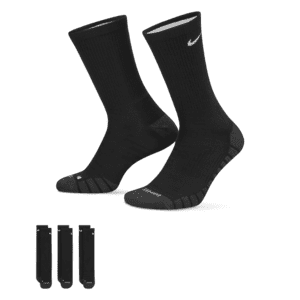

In [8]:
im

In [ ]:
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

Downloading:   0%|          | 0.00/316 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/568 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/862k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

In [ ]:
emb = processor(images=[Image.open(BytesIO(requests.get(filepath).content)).convert('RGB')])

In [ ]:
emb["pixel_values"][0].shape

(3, 224, 224)